In [10]:
import os
import dill as pickle

import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from policy import config
from policy.dataset.dataset_loaders import dataset_loader
from policy.checkpoints import CheckpointIO

model_dir = "/home/mrl/Documents/Projects/tskill/out/PegInsertion/Plan/012"

cfg_path = os.path.join(model_dir, "config.yaml")
cfg = config.load_config(cfg_path, None)
method = cfg["method"]
if method == "plan":
        cfg["vae_cfg"] = config.load_config(os.path.join(cfg["model"]["vae_path"],"config.yaml"))

# index_path = os.path.join(model_dir, "data_info.pickle")
# with open(index_path, 'rb') as f:
#     data_info = pickle.load(f)

# Dataset
cfg["data"]["pad"] = True
cfg["data"]["augment"] = True
cfg["data"]["augmentation"]["subsequence_rate"] = .85
cfg["data"]["full_seq"] = False
cfg["training"]["batch_size"] = 1
cfg["training"]["use_precalc"] = False
# cfg["model"]["autoregressive_decode"] = True

train_dataset, val_dataset = dataset_loader(cfg,
                                            save_override=True,
                                            fullseq_override=True)

Found existing multitask data info file
>>> Loading multitask dataset from file: out/PegInsertion/Plan/012/data_info.pickle
Loading dataset: /home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90/KITCHEN_SCENE6_close_the_microwave_demo.hdf5
Loading indices from file: out/PegInsertion/Plan/012/data_info.pickle
Overriding full seq config!
Loading dataset: /home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90/LIVING_ROOM_SCENE6_put_the_chocolate_pudding_to_the_left_of_the_plate_demo.hdf5
Loading indices from file: out/PegInsertion/Plan/012/data_info.pickle
Overriding full seq config!
Loading dataset: /home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90/KITCHEN_SCENE10_close_the_top_drawer_of_the_cabinet_demo.hdf5
Loading indices from file: out/PegInsertion/Plan/012/data_info.pickle
Overriding full seq config!
Loading dataset: /home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90/KITCHEN_SCENE3_put_the_moka_pot_on_the_stove_demo.h

In [11]:
from IPython.display import display, clear_output
fig = plt.figure(1, figsize=(10,10))
ax1,ax2 = fig.subplots(1,2)
i = 0
for data in train_dataset:
    i += 1
    display(i)
    ax1.imshow(data["rgb"][0,0,0,...].permute(1,2,0))
    ax2.imshow(data["goal"][0,0,0,...].permute(1,2,0))
    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)

40

KeyboardInterrupt: 

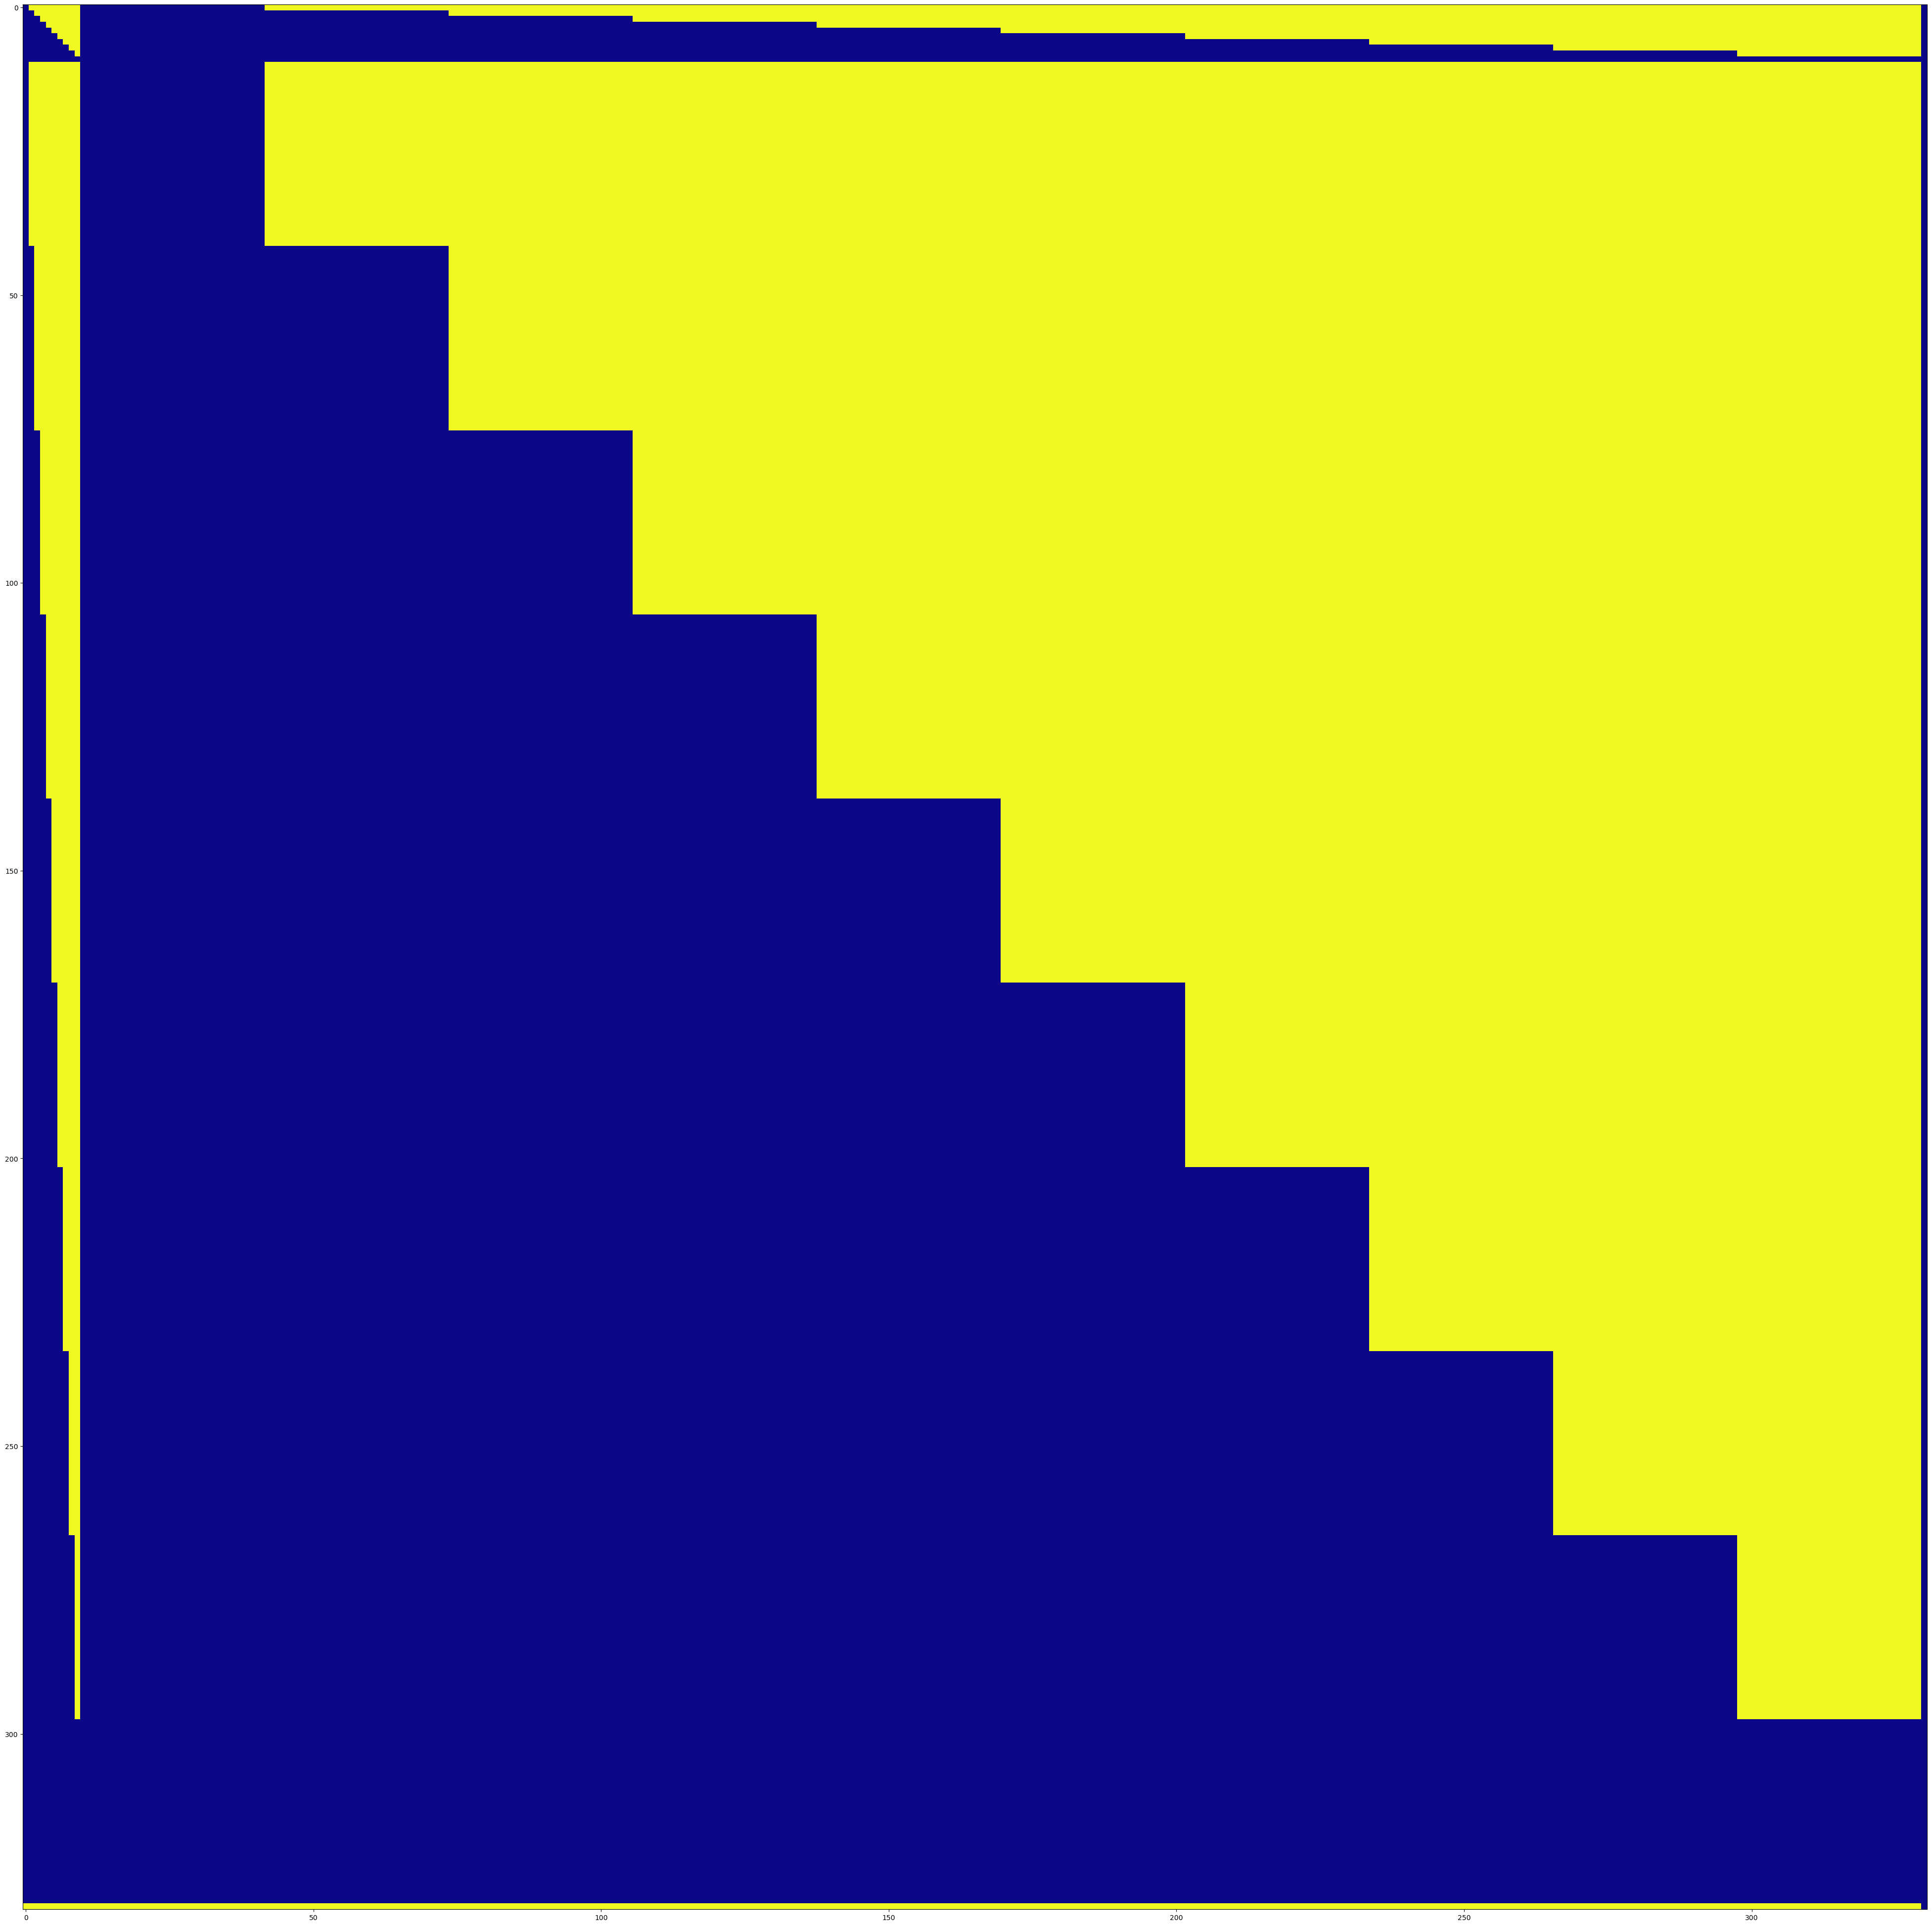

In [14]:
from policy.dataset.masking_utils import get_dec_ar_masks, get_plan_ar_masks, get_enc_causal_masks

torch.set_printoptions(threshold=10000)
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
plt.close()
i = 1

plan_src_mask, plan_mem_mask, plan_tgt_mask = get_plan_ar_masks(16*2, 20)
dec_src_mask, dec_mem_mask, dec_tgt_mask = get_dec_ar_masks(16*2, 10)
enc_src_mask, enc_mem_mask, enc_tgt_mask = get_enc_causal_masks(200, 20, 10)

mask = dec_src_mask

fig = plt.figure(1, figsize=(50,50))
ax1 = fig.subplots(1,1)
# ax1.xaxis.set_major_locator(MultipleLocator(10))
# ax1.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_major_locator(MultipleLocator(10))
# ax1.yaxis.set_minor_locator(MultipleLocator(1))

ax1.imshow(mask.squeeze(0).to(torch.int), cmap="plasma")

# path = "/home/mrl/Documents/Projects/tskill/ERROR_DATA.pickle"
# with open(path, "rb") as f:
#     data = pickle.load(f)

# Images
# print(data["rgb"].shape)
# n = data["rgb"].shape[0]
# n_cams = data["rgb"].shape[1]
# for im in range(50):
#     fig = plt.figure(im)
#     axes = fig.subplots(1,n_cams)
#     for c in range(n_cams):
#         axes[c].imshow(data["rgb"][im,c,...].permute(1,2,0))
    # ax3.imshow(data["enc_mask"].to(torch.int))
    # ax4.imshow(data["dec_mask"].to(torch.int))

# Masks
# bs = data["actions"].shape[0]
# enc_mask = data["enc_mask"][0,...]
# for b in range(bs):
#     fig = plt.figure(b, figsize=(20,10))
#     ax1, ax2, ax3= fig.subplots(1,3)
#     seq_pad_mask = data["seq_pad_mask"][b,...]
#     seq_pad_mask = seq_pad_mask.unsqueeze(0).repeat(4*seq_pad_mask.shape[0], 4)
#     print(torch.logical_not((seq_pad_mask[0,...] | data["enc_mask"][b,0,...])).to(torch.int).sum())
#     ax1.imshow(data["enc_mask"][b,...].to(torch.int))
#     ax2.imshow(seq_pad_mask.to(torch.int))
#     ax3.imshow((data["enc_mask"][b,...] | seq_pad_mask).to(torch.int))

# data["enc_mask"][3,...] = torch.zeros_like(data["enc_mask"][3,...])


In [3]:
# Model
model = config.get_model(cfg, device="cpu")
checkpoint_io = CheckpointIO(model_dir, model=model)
load_dict = checkpoint_io.load("model_best.pt")
model.train()
out = model(data)

/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_We

freezing state encoder network!
/home/mrl/Documents/Projects/tskill/out/PegInsertion/VAE/059/model_best.pt
=> Loading checkpoint from local file...
load state dict: <All keys matched successfully>
Freezing state encoder network!
/home/mrl/Documents/Projects/tskill/out/PegInsertion/Plan/027/model_best.pt
=> Loading checkpoint from local file...
load state dict: <All keys matched successfully>


KeyError: 'rgb'